In [4]:
import torch
import torch.nn.functional as F
import numpy as np

In [7]:
from copy import deepcopy
import os
import gym
import json
from tqdm import tqdm

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

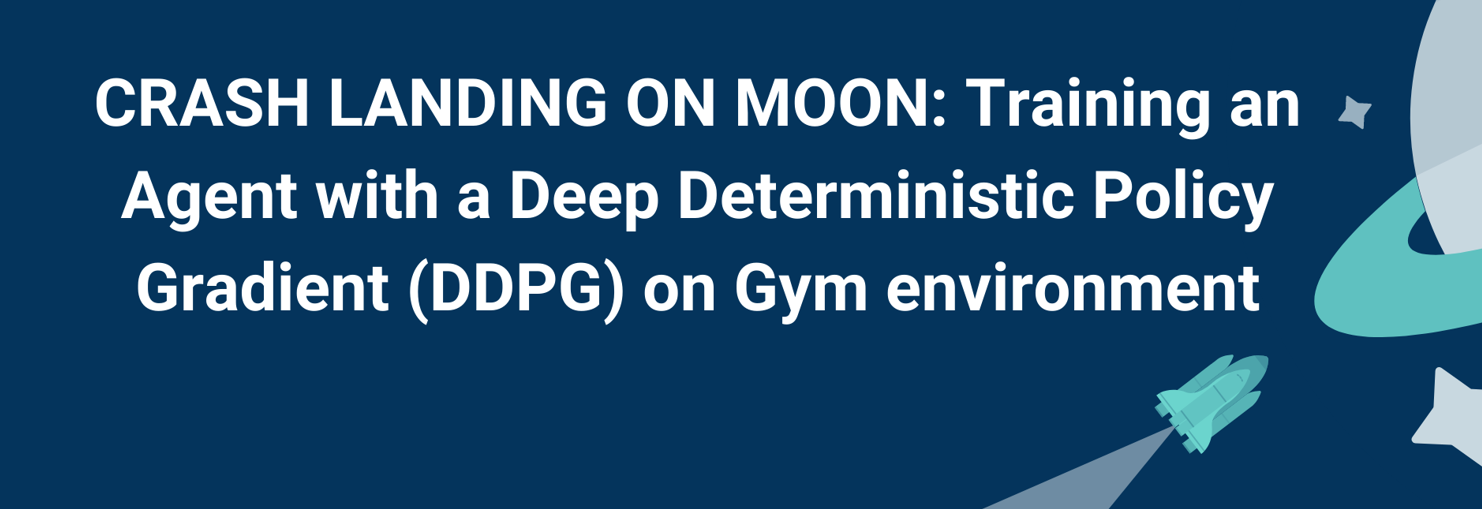

# Introduction


In Reinforcement Learning algorithms, the common goal is to train an agent. This agent learns to get a policy that determines actions for an environment to maximize the reward obtained. Reinforcement algorithms that incorporate deep learning, we call these algorithms *Deep Reinforcement Learning*. Deep RL agents can beat even world champions at the game of GO.

<b><center> Figure 1. Training an agent (cat) to get the fish without being caught with a monster. </center> </b>

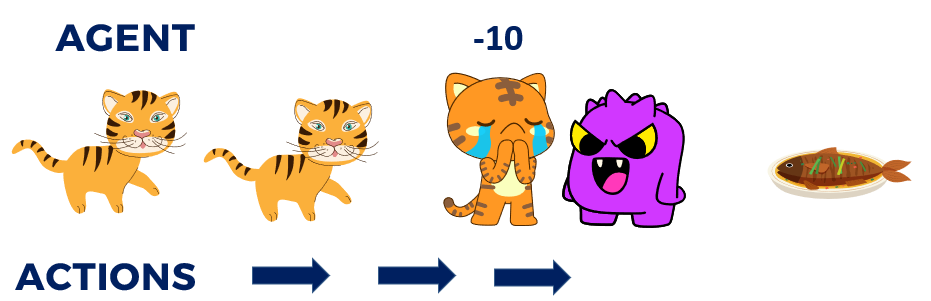

<b>After some training, the agent learned the best strategy and earns a +100 reward. </b>

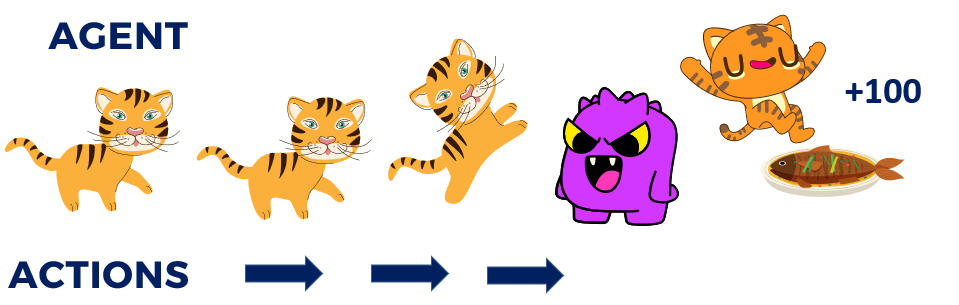

Deep Q-Network (DQN) is a value-based reinforcement learning that has shown good performance in solving problems with high-dimensional observation spaces. However, it can only handle discrete and low-dimensional action spaces. moreover, they are still limited to deterministic policies. To address these shortcomings, we can use another policy learning, the deep deterministic policy gradient (DDPG).

Deep Deterministic Policy Gradien is a model-free off-policy algorithm for learning continous actions. It combines ideas from DPG (Deterministic Policy Gradient) and DQN (Deep Q-Network). It uses *Experience Replay* and *slow-learning target networks* from DQN, and it is based on DPG, which can operate over continuous action spaces.

This work will explore an extremely simplified Lunar Gym environment from OpenAI and attempt to train a computerized agent
to perform a successful moon landing. The action space in this environment consists of continuous control variables for 3 engines onboard a lunar lander that must be utilized by the computer agent in order to safely bring the lander to rest on the landing pad. 

What make this problem challenging for Q-Learning Algorithms is that actions are continuous instead of being discrete. The approach to solve this continuous control problem is the application of a Deep Deterministic Policy
Gradient (DDPG) algorithm. The objective of the DDPG agent is to learn an optimal state-action value function during mission training and then use it to attempt a successful lunar landing.

# Quick Theory

The Deep Deterministic Policy Gradient (DDPG) algorithm was chosen as the method to solve this problem because it is
uniquely equipped for environments with continuous action spaces. To demonstrate how and why the DDPG
algorithm is suitable for these types of problems, let us begin with the basic theory and motivation behind Q-Learning. If
an optimal state-action value function is known, then in any given state the optimal action is:


\begin{equation}
a^*(s) = \arg \max_a Q^*(s,a)
\end{equation}


When there is a finite set (of reasonable size) of discrete actions, then computing the maximum over the action space
can be done directly in a reasonable amount of time. However, when the action space becomes continuous, the value of every state-action pair cannot be directly computed efficiently in order to compute the maximum. Thus the assumption is
made that the optimal state-action value function \$ Q^*(s,a)\$ is differentiable with respect to the action variable $a$ because the action space is continuous. This allows for an efficient gradient-based learning rule for a policy over the state space. [1]

The DDPG algorithm consists of two concurrent learning tasks:
1. learning a Q function
2. learning a policy

## Learning a Q-function in DPPG
Before describing the first learning task, recall the *Bellman equation* which describes the optimal state-action value function for Q-Learning problems:
\begin{equation}
Q^*(s,a) = \underset{s' \sim P}{{\mathrm E}}\Big[r(s,a) + \gamma \max_{a'} Q^*(s', a')\Big]
\end{equation}
where $s'$~$P$ represents samples of $s'$ drawn from the environment with probability distribution $P(|s,a)$.

This Bellman equation is the starting point for learning an approximator to $Q^*(s,a)$. Suppose the approximator is a neural network $Q_{\phi}(s,a)$, with parameters $\phi$, and that we have collected a set ${\mathcal D}$ of transitions $(s,a,r,s',d)$ (where $d$ indicates whether state $s'$ is terminal). We can set up a *mean-squared Bellman error* (MSBE) function, which tells us roughly how closely $Q_{\phi}$ comes to satisfying the Bellman equation:

\begin{equation}
L(\phi, {\mathcal D}) = \underset{(s,a,r,s',d) \sim {\mathcal D}}{{\mathrm E}}\Bigg[
    \Bigg( Q_{\phi}(s,a) - \left(r + \gamma (1 - d) \max_{a'} Q_{\phi}(s',a') \right) \Bigg)^2
    \Bigg]
\end{equation}
Here, in evaluating (1-d), we’ve used a Python convention of evaluating True to 1 and False to zero. Thus, when `d==True`—which is to say, when $s'$ is a terminal state—the Q-function should show that the agent gets no additional rewards after the current state. The objective of Q-learning algorithms for function approximators, such as DQN (and all its variants) and DDPG, is then to minimize the MSBE loss function in order to approximate the true state-action value function.

### Target Networks
Q-learning algorithms make use of target networks. The term
\begin{equation}
r + \gamma (1 - d) \max_{a'} Q_{\phi}(s',a')
\end{equation} 
is called the *target*, because when we minimize the MSBE loss, we are trying to make the Q-function be more like this target. Problematically, the target depends on the same parameters we are trying to train: $\phi$. This makes MSBE minimization unstable. The solution is to use a set of parameters which comes close to $\phi$, but with a time delay—that is to say, a second network, called the target network, which lags the first. The parameters of the target network are denoted $\phi_{\text{targ}}$.

In DQN-based algorithms, the target network is just copied over from the main network every some-fixed-number of steps. In DDPG-style algorithms, the target network is updated once per main network update by polyak averaging:
\begin{equation}
\phi_{\text{targ}} \leftarrow \rho \phi_{\text{targ}} + (1 - \rho) \phi,
\end{equation} 

### Calculating the Max Over Actions in the Target
As mentioned earlier, computing the maximum over actions in the target is a challenge in continuous action spaces. DDPG deals with this by using a *target policy network* to compute an action which approximately maximizes $Q_{\phi_{\text{targ}}}$. The target policy network is found the same way as the target Q-function: by polyak averaging the policy parameters over the course of training.

Putting it all together, Q-learning in DDPG is performed by minimizing the following MSBE loss with stochastic gradient descent:
\begin{equation}
L(\phi, {\mathcal D}) = \underset{(s,a,r,s',d) \sim {\mathcal D}}{{\mathrm E}} \Bigg[\Bigg( Q_{\phi}(s,a) - \left(r + \gamma (1 - d) Q_{\phi_{\text{targ}}}(s', \mu_{\theta_{\text{targ}}}(s')) \right) \Bigg)^2\Bigg]
\end{equation}    
where $\mu_{\theta_{\text{targ}}}$ is the target policy.

## The Policy Learning Side of DDPG
Policy learning in DDPG is fairly simple. We want to learn a deterministic policy $\mu_{\theta}(s)$ which gives the action that maximizes $Q_{\phi}(s,a)$. Because the action space is continuous, and we assume the Q-function is differentiable with respect to action, we can just perform gradient ascent (with respect to policy parameters only) to solve

\begin{equation}
\max_{\theta} \underset{s \sim {\mathcal D}}{{\mathrm E}}\left[ Q_{\phi}(s, \mu_{\theta}(s)) \right]
\end{equation}

### Exploration vs. Exploitation
DDPG trains a deterministic policy in an off-policy way. Because the policy is deterministic, if the agent were to explore on-policy, in the beginning it would probably not try a wide enough variety of actions to find useful learning signals. To make DDPG policies explore better, we add noise to their actions at training time. The authors of the original DDPG paper recommended time-correlated `OU noise`, but more recent results suggest that uncorrelated, mean-zero Gaussian noise works perfectly well. Since the latter is simpler, it is implemented in this study.


### Replay Buffers
All standard algorithms for training a deep neural network to approximate $Q^*(s,a)$ make use of an experience replay buffer. This is the set ${\mathcal D}$ of previous experiences. In order for the algorithm to have stable behavior, the replay buffer should be large enough to contain a wide range of experiences, but it may not always be good to keep everything. If you only use the very-most recent data, you will overfit to that and things will break; if you use too much experience, you may slow down your learning. This may take some tuning to get right.

## DDPG model architecture

<center><b>Figure 2. DQN vs DDPG networks [2]</b></center>
    
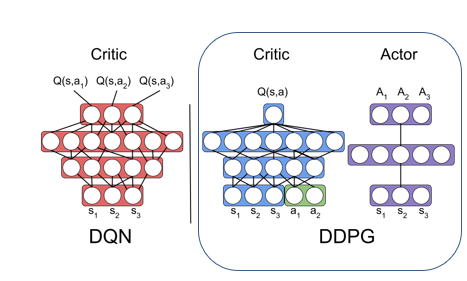

The primary difference between the DQN and DDPG is that DDPG has two networks which we call Actor and Critic networks. The actor proposes an action given a state while the critic predicts if the action is good or bad. For DQN network, it is just a single network where it tries to predict the Q values for each state-action pair [3]. The actor-critic algorithm along with deep function approximation allows the DDPG agent to learn high dimensional and continuous action space.



# Methodology

## Pipeline

<center><b>Figure 3. Summary of Methodology</center></b>
    
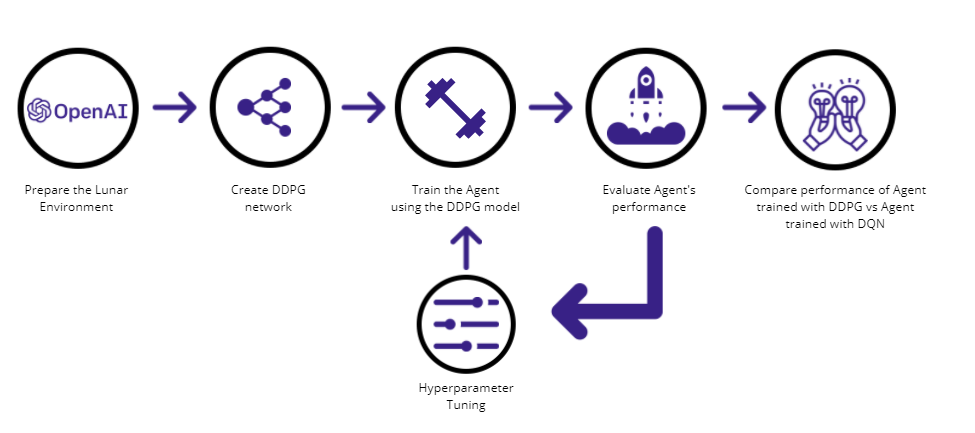

## Understanding the Environment

### Task

This environment (LunarLanderContinuous-v2) is a continuous control tasks in the Box2D simulator.
The goal is to train an agent to control the landing of a rocket into a landing pad.
In this environment, landing outside the landing pad is possible.
Fuel is infinite, so an agent can learn to fly and then land on its first attempt.
The environment is found in this  [link](https://gym.openai.com/envs/LunarLanderContinuous-v2/).
### Actions

Action is two real values-vector from -1 to +1. 
The first value controls main engine, where `[-1,0]` is off and `(0, +1]` throttle from 50% to 100% power. 
The second value controls `[-1.0,-0.5)` fire left engine, `(+0.5, +1.0]` fire right engine, and `[-0.5, 0.5]` is off.

### States
The state of the lander is encoded in 8 variables:
- x position
- y position
- x velocity
- y velocity
- angle
- angular velocity
- left leg touching ground
- right leg touching ground

### Rewards
As the agent observes the current state of the environment and chooses
an action, the environment *transitions* to a new state, and also
returns a reward that indicates the consequences of the action.
This environment rewards the agent for the following:
- -100 lander crashed or lands outside landing pad (ends an episode)
- +100 lander comes to rest within landing pad (ends an episode)
- +10 for each leg currently on the ground (lifting a leg incurs a -10 reward)
- -0.3 for each frame the main engine is used
- -0.03 for using the side engines
- There are miscellaneous positive (negative) rewards for decreasing (increasing) the distance to the landing pads.

The rewards incentivise the agent for landing inside the landing pad on both legs, while using the least amount of fuel as possible.

## DDPG architecture

This DDPG architecture was inspired from this Github [source](https://github.com/soumik12345/DDPG).

In [6]:
class ReplayBuffer(object):

    def __init__(self, state_dimension, action_dimension, max_size=int(1e6)):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0
        self.state = np.zeros((max_size, state_dimension))
        self.action = np.zeros((max_size, action_dimension))
        self.next_state = np.zeros((max_size, state_dimension))
        self.reward = np.zeros((max_size, 1))
        self.not_done = np.zeros((max_size, 1))
        self.device = torch.device('cuda' if torch.cuda.is_available()
                                           else 'cpu')

    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)
        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.FloatTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device)
                )

In [7]:
class Actor(torch.nn.Module):

    def __init__(self, state_dimension, action_dimension, max_action):
        super(Actor, self).__init__()
        self.l1 = torch.nn.Linear(state_dimension, 400)
        self.l2 = torch.nn.Linear(400, 300)
        self.l3 = torch.nn.Linear(300, action_dimension)
        self.max_action = max_action

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        return self.max_action * torch.tanh(self.l3(a))


class Critic(torch.nn.Module):

    def __init__(self, state_dimension, action_dimension):
        super(Critic, self).__init__()
        self.l1 = torch.nn.Linear(state_dimension + action_dimension, 400)
        self.l2 = torch.nn.Linear(400, 300)
        self.l3 = torch.nn.Linear(300, 1)

    def forward(self, state, action):
        q = F.relu(self.l1(torch.cat([state, action], 1)))
        q = F.relu(self.l2(q))
        return self.l3(q)

In [8]:
class DDPGAgent(object):

    def __init__(self, state_dim, action_dim, max_action, device,
                    discount=0.99, tau=0.005):
        self.device = device
        self.discount = discount
        self.tau = tau
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = deepcopy(self.actor)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters())
        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters())

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(self.device)
        return self.actor(state).cpu().data.numpy().flatten()

    @staticmethod
    def soft_update(local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(),
                                             local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + 
                                        (1.0 - tau) * target_param.data)

    def save_checkpoint(self, filename):
        torch.save(self.critic.state_dict(), filename + '_critic')
        torch.save(self.critic_optimizer.state_dict(), filename + 
                                               '_critic_optimizer')
        torch.save(self.actor.state_dict(), filename + '_actor')
        torch.save(self.actor_optimizer.state_dict(), filename +
                                                   '_actor_optimizer')

    def load_checkpoint(self, filename):
        self.critic.load_state_dict(
            torch.load(
                filename + "_critic",
                map_location=torch.device('cpu')
            )
        )
        self.critic_optimizer.load_state_dict(
            torch.load(
                filename + "_critic_optimizer",
                map_location=torch.device('cpu')
            )
        )
        self.critic_target = deepcopy(self.critic)
        self.actor.load_state_dict(
            torch.load(
                filename + "_actor",
                map_location=torch.device('cpu')
            )
        )
        self.actor_optimizer.load_state_dict(
            torch.load(
                filename + "_actor_optimizer",
                map_location=torch.device('cpu')
            )
        )
        self.actor_target = deepcopy(self.actor)

    def train(self, replay_buffer, batch_size=100):
        state, action, next_state, reward, not_done = replay_buffer.sample(
                                                                batch_size)
        target_q = self.critic_target(next_state,
                                      self.actor_target(next_state))
        target_q = reward + (not_done * self.discount * target_q).detach()
        current_q = self.critic(state, action)
        critic_loss = F.mse_loss(current_q, target_q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        actor_loss = -self.critic(state, self.actor(state)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        DDPGAgent.soft_update(self.critic, self.critic_target, self.tau)
        DDPGAgent.soft_update(self.actor, self.actor_target, self.tau)

In [9]:
class Trainer:

    def __init__(self, params, enable_logging):
        self.enable_logging = enable_logging
        self.config = params
        self.env = gym.make(self.config['env_name'])
        self.apply_seed()
        self.state_dimension = self.env.observation_space.shape[0]
        self.action_dimension = self.env.action_space.shape[0]
        self.max_action = float(self.env.action_space.high[0])
        self.device = torch.device('cuda:0' if torch.cuda.is_available()
                                   else 'cpu')
        self.agent = DDPGAgent(
            state_dim=self.state_dimension, action_dim=self.action_dimension,
            max_action=self.max_action, device=self.device,
            discount=self.config['discount'], tau=self.config['tau']
        )
        self.save_file_name = f"DDPG_{self.config['env_name']
                                            }_{self.config['seed']}"
        self.memory = ReplayBuffer(self.state_dimension,
                                   self.action_dimension)
        if self.enable_logging:
            from torch.utils.tensorboard import SummaryWriter
            self.writer = SummaryWriter('./logs/'
                                        + self.config['env_name'] + '/')
        try:
            os.mkdir('./models')
        except Exception as e:
            pass

    @staticmethod
    def parse_config(json_file):
        with open(json_file, 'r') as f:
            configs = json.load(f)
        return configs

    def apply_seed(self):
        self.env.seed(self.config['seed'])
        torch.manual_seed(self.config['seed'])
        np.random.seed(self.config['seed'])

    def train(self):
        state = self.env.reset()
        done = False
        episode_reward = 0
        episode_timesteps = 0
        episode_num = 0
        evaluations = []
        episode_rewards = []
        for ts in tqdm(range(1, int(self.config['time_steps']) + 1)):
            episode_timesteps += 1
            if ts < self.config['start_time_step']:
                action = self.env.action_space.sample()
            else:
                action = (
                        self.agent.select_action(np.array(state)) +
                        np.random.normal(
                    0, self.max_action * self.config['expl_noise'],
                    size=self.action_dimension
                )
                ).clip(
                    -self.max_action,
                    self.max_action
                )
            next_state, reward, done, _ = self.env.step(action)
            self.memory.add(
                state, action, next_state, reward,
                float(done) if episode_timesteps < 
                                    self.env._max_episode_steps else 0)
            state = next_state
            episode_reward += reward
            if ts >= self.config['start_time_step']:
                self.agent.train(self.memory, self.config['batch_size'])
            if done:
                if self.enable_logging:
                    self.writer.add_scalar('Episode Reward', episode_reward,
                                           ts)
                episode_rewards.append(episode_reward)
                state = self.env.reset()
                done = False
                episode_reward = 0
                episode_timesteps = 0
                episode_num += 1
        if ts % 1000 == 0:
            evaluations.append(evaluate_policy(self.agent, 
                              self.config['env_name'], self.config['seed']))
            self.agent.save_checkpoint(f"./models/{self.save_file_name}")
        return episode_rewards, evaluations

In [10]:
def evaluate_policy(policy, env_name, seed, eval_episodes=10, render=False):
    eval_env = gym.make(env_name)
    eval_env.seed(seed + 100)
    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = eval_env.reset(), False
        while not done:
            action = policy.select_action(np.array(state))
            if render:
                eval_env.render()
            state, reward, done, _ = eval_env.step(action)
            avg_reward += reward
    avg_reward /= eval_episodes
    return avg_reward

## Training the Agent

In [11]:
dict_ = {
  "env_name": "LunarLanderContinuous-v2",
  "seed": 0,
  "discount": 0.99,
  "tau": 5e-3,
  "time_steps": 1e6,
  "start_time_step": 25e3,
  "expl_noise": 0.1,
  "batch_size": 256,
  "evaluate_frequency": 5e3
}
config_file = json.dumps(dict_) 

In [12]:
dict_['env_name']

'LunarLanderContinuous-v2'

In [13]:
trainer = Trainer(dict_, True)
episode_rewards, evaluations = trainer.train()

100%|██████████| 1000000/1000000 [2:43:02<00:00, 102.22it/s] 


In [14]:
# save the trained agent
trainer.agent.save_checkpoint('./models/ddpg_lunarlander_v2_1')

In [18]:
# evaluate agent's performance
evaluations

[241.81596378393365]

# Results and Discussion

To compare the performance of the agent trained using the DDPG algorithm, I also trained another agent using DQN algorithm. The implementation of the DQN reinforcement learning is found on a separate notebook with filename `DQN_agent_training.ipynb`.

I tried different learning rates, gamma, batch size, tau values, and architectures for the Actor and Critic networks. In my initial tests, the best gamma or *discount factor* for both DQN and DDPG was 0.99. Moreover, with 256 batch size, the training for both algorithms were a bit faster. I decided to train both models with 1M timesteps since the learning for both agents at this point were more stable. 

However, readers should take note that the networks for the two agents were different. For the Actor and critic networks of DDPG, both networks had 4 layers, with 2 hidden networks. For the *critic* or target network in DQN, it had 4 layers with 2 Dense hidden layers as well. The main differences were the number of nodes used for each layer and the application of hyperbolic tangent activation function (tanh) in the last layer of the DDPG networks.


The table below shows the initialization and training runtime of the two deep RL models.

<center><b> Table 1. Summary of RL environments, hyperparameters and runtimes </b></center>

|                                    | DDPG                         | DQN                 |   |   |
|------------------------------------|------------------------------|---------------------|---|---|
| environment name                   | LunarLanderContinuous-v2     | LunarLander-v2      |   |   |
| GPU                                | JOJIE default                | JOJIE default       |   |   |
| Training time steps                | 1M                           | 1M                  |   |   |
| Gamma (discount factor)            | 0.99                         | 0.99                |   |   |
| Batch size                         | 256                          | 256                 |   |   |
| Exploration factor                 | Gaussian error (mean 0)      | Linear decay        |   |   |
| Update frequency of Target Network | polyak averaging (rho=0.005) | every 200 timesteps |   |   |
| Training Runtime                   | 2.8 hrs                      | 8.5 hrs             |   |   |
| Evaluation (rewards after training)| 242 over 10 episodes         | 83 over 10 episodes |   |   |

In [23]:
# check the rewards per episode
ddpg_rewards = pd.read_csv('models/ddpg_episode_rewards_1M_v2.csv')
ddpg_rewards.columns = ['episodes', 'rewards']
print('Number of episodes done in 1M training times: ', len(ddpg_rewards))
ddpg_rewards.head()

Number of episodes done in 1M training times:  4295


,episodes,rewards
0,0,-369.553948
1,1,-44.866198
2,2,-233.765157
3,3,-114.926431
4,4,-55.917754


In [26]:
dqn_rewards = pd.read_csv('models/dqn_episode_rewards_1000000.csv')
dqn_rewards.columns = ['episodes', 'rewards']
print('Number of episodes done in 1M training times: ', (len(df_dqn)))
dqn_rewards.head()

Number of episodes done in 1M training times:  3969


,episodes,rewards
0,0,-119.877423
1,1,-192.027020
2,2,-187.927808
3,3,-180.375042
4,4,-320.206227


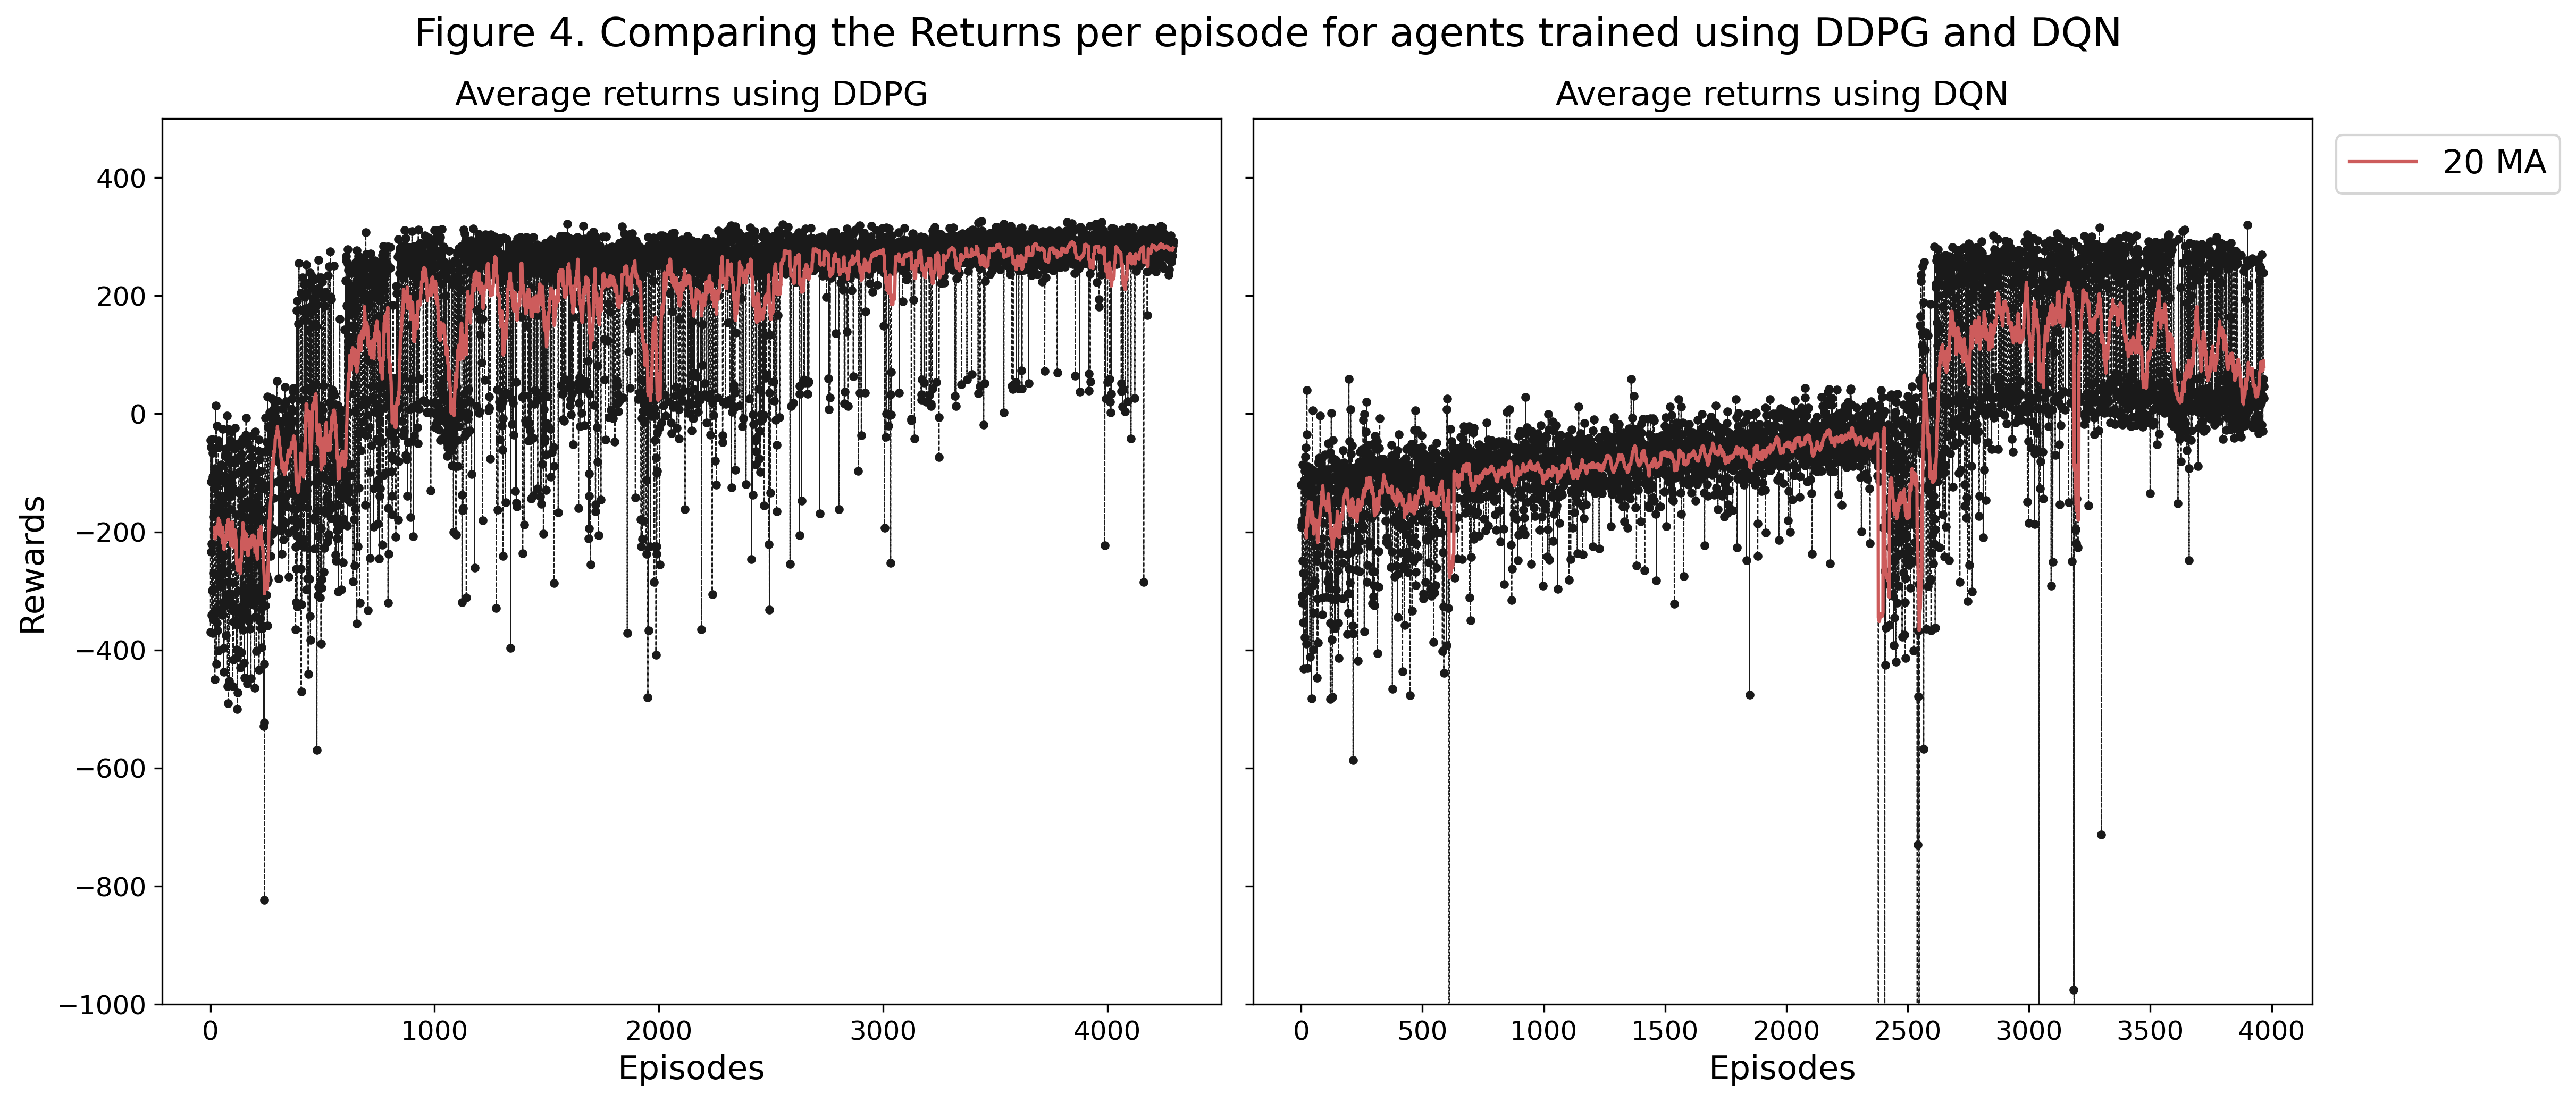

In [84]:
# Compute the 20 episode moving average for DDPG and DQN rewars
rolling_mean_ddpg = ddpg_rewards['rewards'].rolling(window=20).mean()
rolling_mean_dqn = dqn_rewards['rewards'].rolling(window=20).mean()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True,
                               figsize=(16,7), dpi=300)
ax1.set_ylim(-1000, 500)
ax1.set_ylabel('Rewards', fontsize=15)
ax1.set_xlabel('Episodes', fontsize=15)
ax1.plot(ddpg_rewards['rewards'], c="0.1", lw=0.5, ls="--", marker="o", ms=3)
ax1.plot(rolling_mean_ddpg, c="indianred", label="20 MA")
ax1.set_title('Average returns using DDPG', fontsize=15)
ax1.tick_params(axis='both', labelsize=12)

ax2.plot(df_dqn['rewards'], c="0.1", lw=0.5, ls="--", marker="o", ms=3)
ax2.plot(rolling_mean_dqn, c="indianred", label="20 MA")
ax2.set_title('Average returns using DQN', fontsize=15)
ax2.set_xlabel('Episodes', fontsize=15)
ax2.tick_params(axis='both', labelsize=12)

plt.suptitle('Figure 4. Comparing the Returns per episode for'
             ' agents trained using DDPG and DQN', fontsize=18)
plt.legend(bbox_to_anchor=[1.25,1], fontsize=15)
fig.tight_layout()
plt.show()

There are 2 different LunarLander environments in OpenAIGym. [LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/) has discrete action space while [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2/) has continuous action space.  For the discrete environment, actions are discrete. For the continuous environment, action is two real values-vector from -1 to +1. The agent "learns" if it can obtain an average reward of 200 after training. 

For the training runtimes, training the agent with DDPG was faster as it took only 2.8 hrs while training with DQN took 8.5 hrs. Both were trained with 1M timesteps using GPU on Jojie. However, the significant difference of the runtimes could be due to the difference in the libraries. For DDPG, *pyTorch* was used while the DQN implemented was in *keras*. Figure 4 shows the rewards per episode (black) and the 20-period moving average rewards (red) during the whole training. As shown in the figure above, the average episodic rewards for both increase with time. However, DDPG agent learned faster.

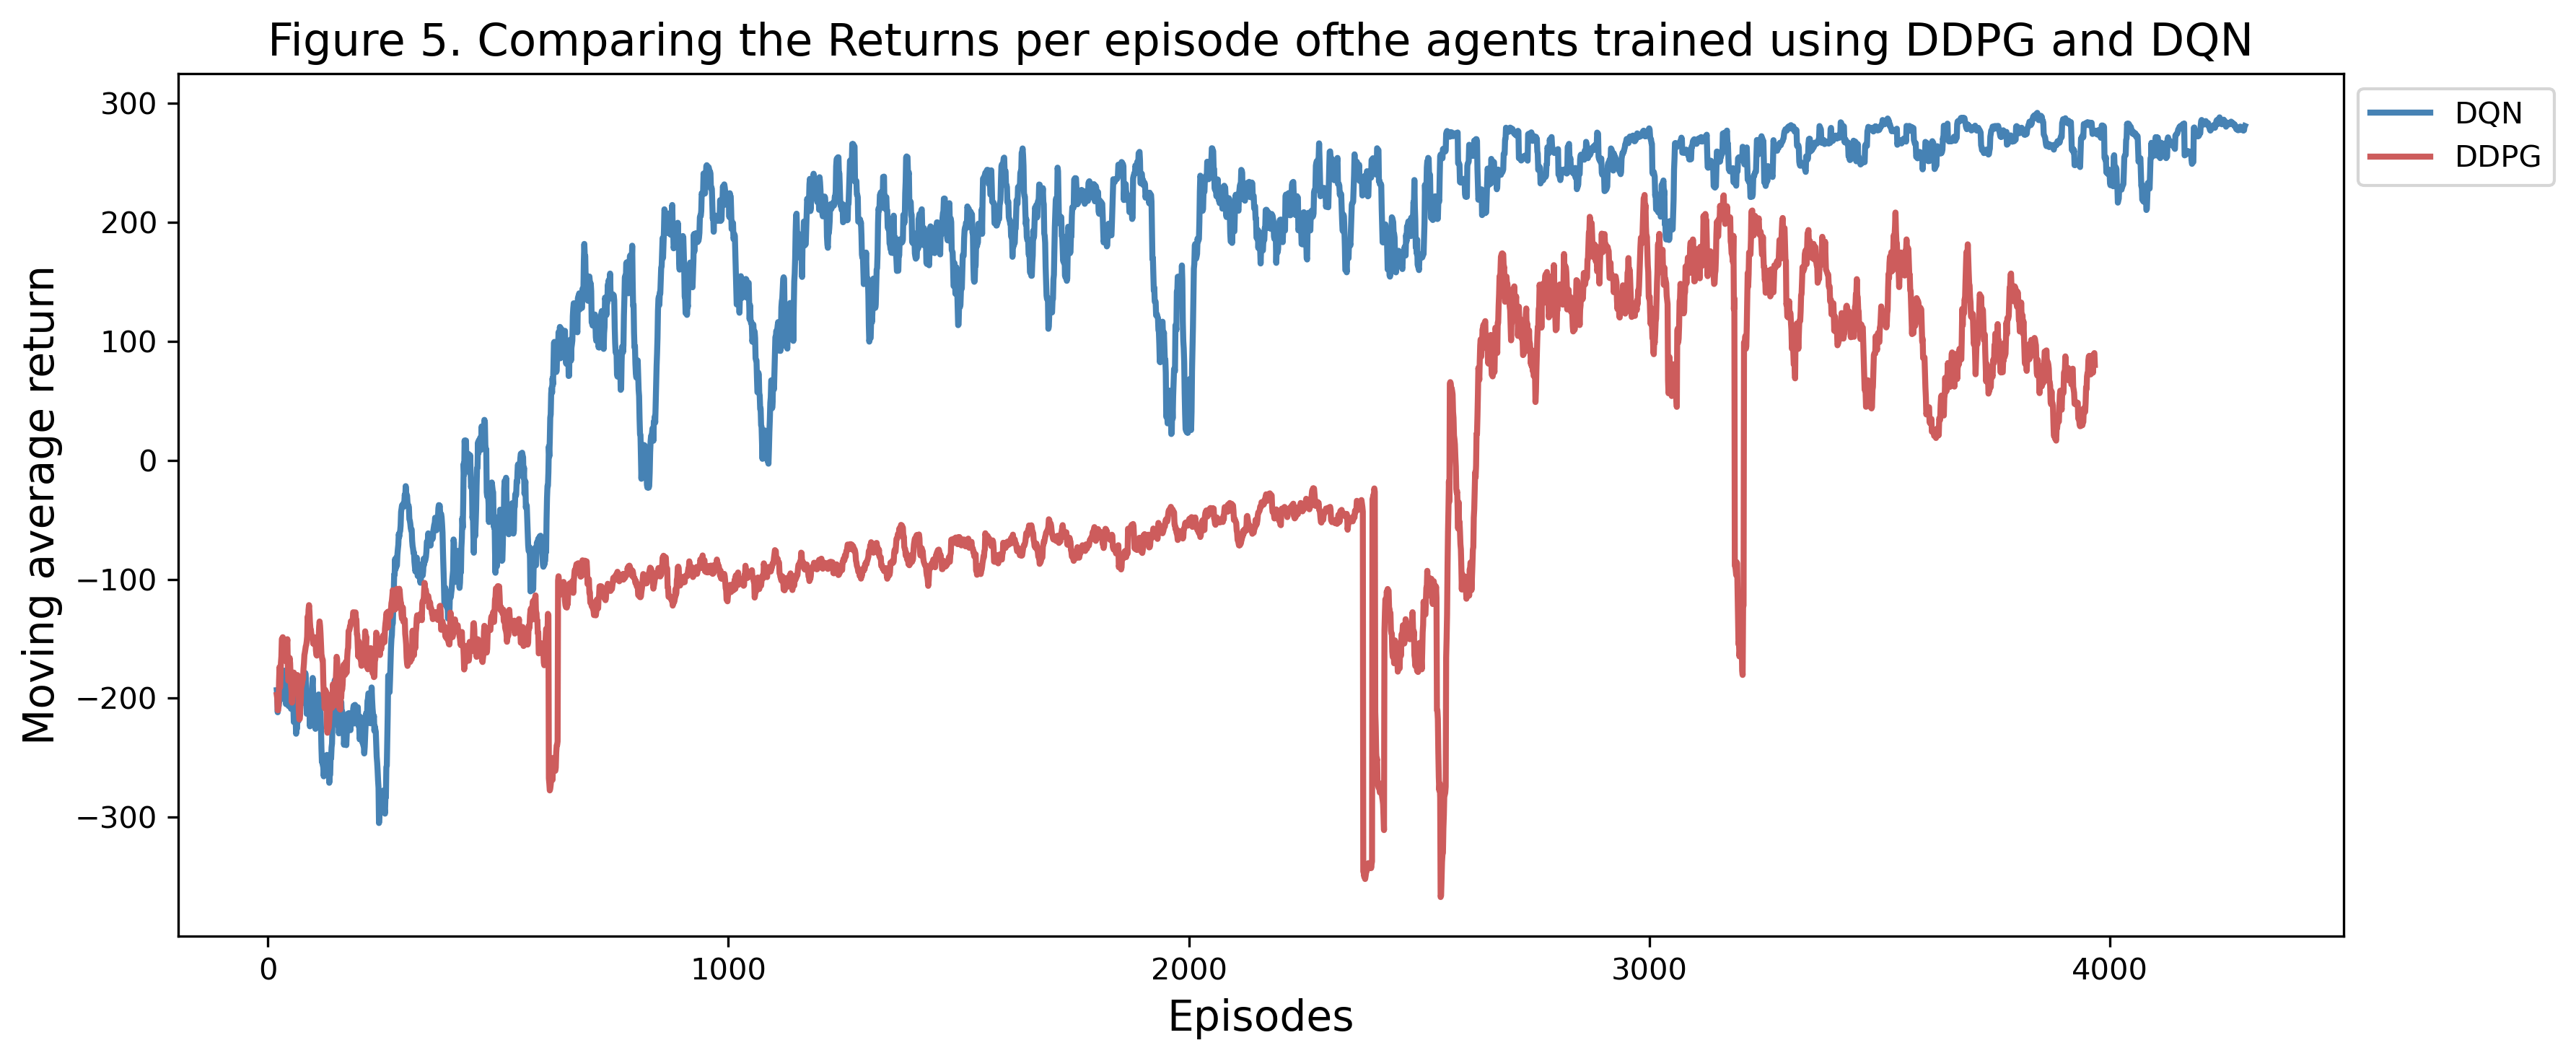

In [82]:
plt.figure(dpi=300, figsize=(12,5))
plt.plot(rolling_mean_ddpg, c="steelblue", label="DQN", lw=2)
plt.plot(rolling_mean_dqn, c="indianred", label="DDPG", lw=2)
plt.legend(bbox_to_anchor=[1,1])
plt.xlabel("Episodes", fontsize=14)
plt.ylabel("Moving average return", fontsize=14)
plt.title('Figure 5. Comparing the Returns per episode of'
             'the agents trained using DDPG and DQN', fontsize=15)
plt.tight_layout()
plt.show()

The LunarLanding problem is a complex task, but DDPG implemented on this project worked great! The Figure 5 above shows the 20-period moving average. The agent trained with DDPG learned fast and was more stable than agent trained with DQN. As you can see on the plot, the learning started to stabilize, and the DDPG agent obtained positive returns  after the 1000th episode. For the DQN, the agent was unstable. Even after the 3000th episode, the agent obtained a negative reward.

For testing,  I evaluated the 2 agents with 10 episodes with no updates. The moving average reward for DDPG is 242. While only 83 for DQN.


# Key Takeaways

- DDPG algorithm handles continuous and high-dimensional action spaces.
- DDPG is heavily dependent on searching for the correct hyperparameters for the current task.
    - For this environment, DDPG worked well with more training times. However, DDPG might not work well with other high-dimensional, complex, continuous environments.
- The number of hyperparameters for DDPG to fine tune is pretty much double than that of in DQN. 
    - This is because with DDPG, I only had to fine tune not 1 but two neural network models. Moreover, the performance of the actor model strongly depends on the critics performance. Hence, it's important that they both have proper stable growth which is quite difficult to assure.

# References

[1] Deep Deterministic Policy Gradient — Spinning Up documentation. (2018). Retrieved 12 March 2022, from https://spinningup.openai.com/en/latest/algorithms/ddpg.html#quick-facts

[2]. Image source. Retrieved 12 March 2022, from https://media-exp1.licdn.com/dms/image/C4E12AQHeeXc5kG0hZw/article-inline_image-shrink_1000_1488/0/1593424485158?e=1652313600&v=beta&t=VMbkWe8CpSyDsrlJU_9MlReN459ThL0-iD3RQzMKT2A

[3] Deep Deterministic Policy Gradient — Spinning Up documentation. (2020). Retrieved 12 March 2022, from https://spinningup.openai.com/en/latest/algorithms/ddpg.html#quick-facts

